<a href="https://colab.research.google.com/github/vaibhavsundharam/Face-Anti-Spoofing/blob/master/Face_Anti_Spoofing_NUAA_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# General Initializations

In [ ]:
import torch
import sys
import os
from __future__ import print_function, division
import matplotlib.pyplot as plt
from torchvision import transforms, utils
import torchvision.transforms as transforms
import torchvision.models as models
from skimage.transform import resize
import torch.nn as nn
import torch.nn.functional as F
import cv2
import re
import pandas as pd
import numpy as np

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
plt.ion()   # interactive mode


In [ ]:
torch.cuda.is_available()

False

In [ ]:
# Set device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [ ]:
prefix = '/content/gdrive/My Drive/'
# modify "customized_path_to_your_project" 
customized_path_to_your_project = '/content/gdrive/My Drive/Machine Learning/Face Anti-spoofing/' # enter the main directory (change location as required)
sys_path = os.path.join(prefix, customized_path_to_your_project)
sys.path.append(sys_path)
print(f"System path: {sys_path}")

System path: /content/gdrive/My Drive/Machine Learning/Face Anti-spoofing/


In [ ]:
# reading the text file with real and fake faces
data_directory=sys_path+"Data/"
print(f"Data directory location:{data_directory}")

Data directory location:/content/gdrive/My Drive/Machine Learning/Face Anti-spoofing/Data/


#Data Preprocessing

In [ ]:
# combining real and fake faces file for training and dev

client_train_txt_file=data_directory+"NormalizedFace/client_train_face.txt"  
imposter_train_txt_file=data_directory+"NormalizedFace/imposter_train_face.txt"

client_train_images_loc=data_directory+"NormalizedFace/ClientFace/" 
imposter_train_images_loc=data_directory+"NormalizedFace/ImposterFace/"

train_dev_data=[(client_train_txt_file, client_train_images_loc, 1), (imposter_train_txt_file, imposter_train_images_loc, 0 )] # encoding the class

train_dev_img_list=list() # list containing the location of images 

with open("train_combined.txt", "w") as out:
  for a,b,c in train_dev_data:
    with open(a, "r") as file:
      for line in file:        
        line=line.rstrip()
        folder=re.findall("([0-9]+)\\\\", line)[0]
        image=re.findall("[0-9_]+.bmp", line)[0]
        train_dev_img_list.append(b+folder+"/"+image+"/"+str(c))
        out.write(b+folder+"/"+image+"/"+str(c)+"\n") #-----> format: folder/image_name

read_file_train=pd.read_csv (r'/content/train_combined.txt', header = None)
read_file_train.columns = ["image"]
read_file_train.to_csv (r"train_combined.csv", index=None)

print(f"Total number of examples for training: {len(read_file_train)}")

Total number of examples for training: 3491


In [ ]:
# combining real and fake faces file for testing and converting it to a csv 

client_test_txt_file=data_directory+"NormalizedFace/client_test_face.txt"
imposter_test_txt_file=data_directory+"NormalizedFace/imposter_test_face.txt"

client_test_images_loc=data_directory+"NormalizedFace/ClientFace/" 
imposter_test_images_loc=data_directory+"NormalizedFace/ImposterFace/"

test_data=[(client_test_txt_file,client_test_images_loc, 1),(imposter_test_txt_file, imposter_test_images_loc, 0)]

test_img_list=list() # list containing the location of images 

with open("test_combined.txt", "w") as out:
  for a,b,c in test_data:
    with open(a, "r") as file:
      for line in file:        
        line=line.rstrip()
        folder=re.findall("([0-9]+)\\\\", line)[0]
        image=re.findall("[0-9_]+.bmp", line)[0]
        test_img_list.append(b+folder+"/"+image+"/"+str(c))
        out.write(b+folder+"/"+image+"/"+str(c)+"\n") #-----> format: folder/image_name
        
read_file_test = pd.read_csv (r'/content/test_combined.txt', header = None)
read_file_test.columns = ["image"]
read_file_test.to_csv (r"test_combined.csv", index=None)

print(f"Total number of examples for testing: {len(read_file_test)}")


Total number of examples for testing: 9123


# Data loaders and data augmentation

In [ ]:
# custom class to explore dataset

from torch.utils.data import Dataset, DataLoader
from PIL import Image

class face_dataset(Dataset):
  def __init__(self, data_split_csv_loc, transform=None): 
    self.data_split_csv_loc=pd.read_csv(data_split_csv_loc)    
    self.transform=transform    
    

  def __len__(self):  # returns the length of the data set
     return len(self.data_split_csv_loc)

  def __getitem__(self, idx):    
    img_loc=self.data_split_csv_loc.iloc[idx,0][:-2]           
    img_class=int(self.data_split_csv_loc.iloc[idx,0][-1])
    img_transform=self.transform(Image.open(img_loc))    
    
    return  img_transform,   img_class  #---> returned values are a touple and image class 

In [ ]:
# LBP+sharpen for transforms 

from skimage.feature import local_binary_pattern

class to_LBP():
  '''class to calculate LBP'''

  def __init__(self, n_points_radius, method):
    self.n_points=n_points_radius
    self.method=method       
    self.channels=len(self.n_points) 
    self.kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
    

  def  __call__(self, sample):       
    w, h=sample.size
    temp=np.zeros((self.channels, w, h))   
    image=np.array(sample)    
    image=cv2.filter2D(image, -1, self.kernel)    
    for idx, values in enumerate(self.n_points):             
      lbp=local_binary_pattern(image, values[0], values[1], self.method)              
      temp[idx]=lbp      
    return (temp,  image)

In [ ]:
# Here we create two seperate instances of the face_dataset class. One will hold the data set for training and the other will hold data for dev

lbp_maps=lbp_maps=[(3,3),(4,1), (4,2), (8,1), (8,2), (8,3), (8,5), (16,2), (16,3), (16,5)]
num_input_channels=len(lbp_maps)
print(f"Number of input channels: {num_input_channels}")

train_dataset=face_dataset(data_split_csv_loc="/content/train_combined.csv", transform=transforms.Compose([transforms.Resize((64,64)),  transforms.RandomHorizontalFlip(),  to_LBP(n_points_radius=lbp_maps, method="uniform")]))
test_dataset=face_dataset(data_split_csv_loc="/content/test_combined.csv", transform= transforms.Compose([transforms.Resize((64,64)),   to_LBP(n_points_radius=lbp_maps, method="uniform")]))


len_train_dataset, len_test_dataset, =len(train_dataset), len(test_dataset) 
print(f"Total number of elements in training dataset: {len_train_dataset}")
print(f"Total number of elements in test dataset: {len_test_dataset}")

Number of input channels: 10
Total number of elements in training dataset: 3491
Total number of elements in test dataset: 9123


#Data Exploration

In [ ]:
# function for plotting LBP 

def plot( touple):   
  fig, axs = plt.subplots(touple[0].shape[0], touple[0].shape[1]+1, figsize=(25,25))  
  
  """plotting the images on which lbp is calculated """
  for img in range(touple[1].shape[0]):
    axs[img, 0 ].imshow(touple[1][img])

  """plotting the LBP of the image """     
  for example in range(touple[0].shape[0]):
    for image in range(touple[0].shape[1]):
      axs[example, image+1].imshow(touple[0][example][image])

In [ ]:
plot_loader=DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=8) 

for batch, label  in plot_loader:  # getting one batch for visualizing data  
  print(batch[0].shape)
  
  break
  

torch.Size([16, 10, 64, 64])


label: tensor([1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1])


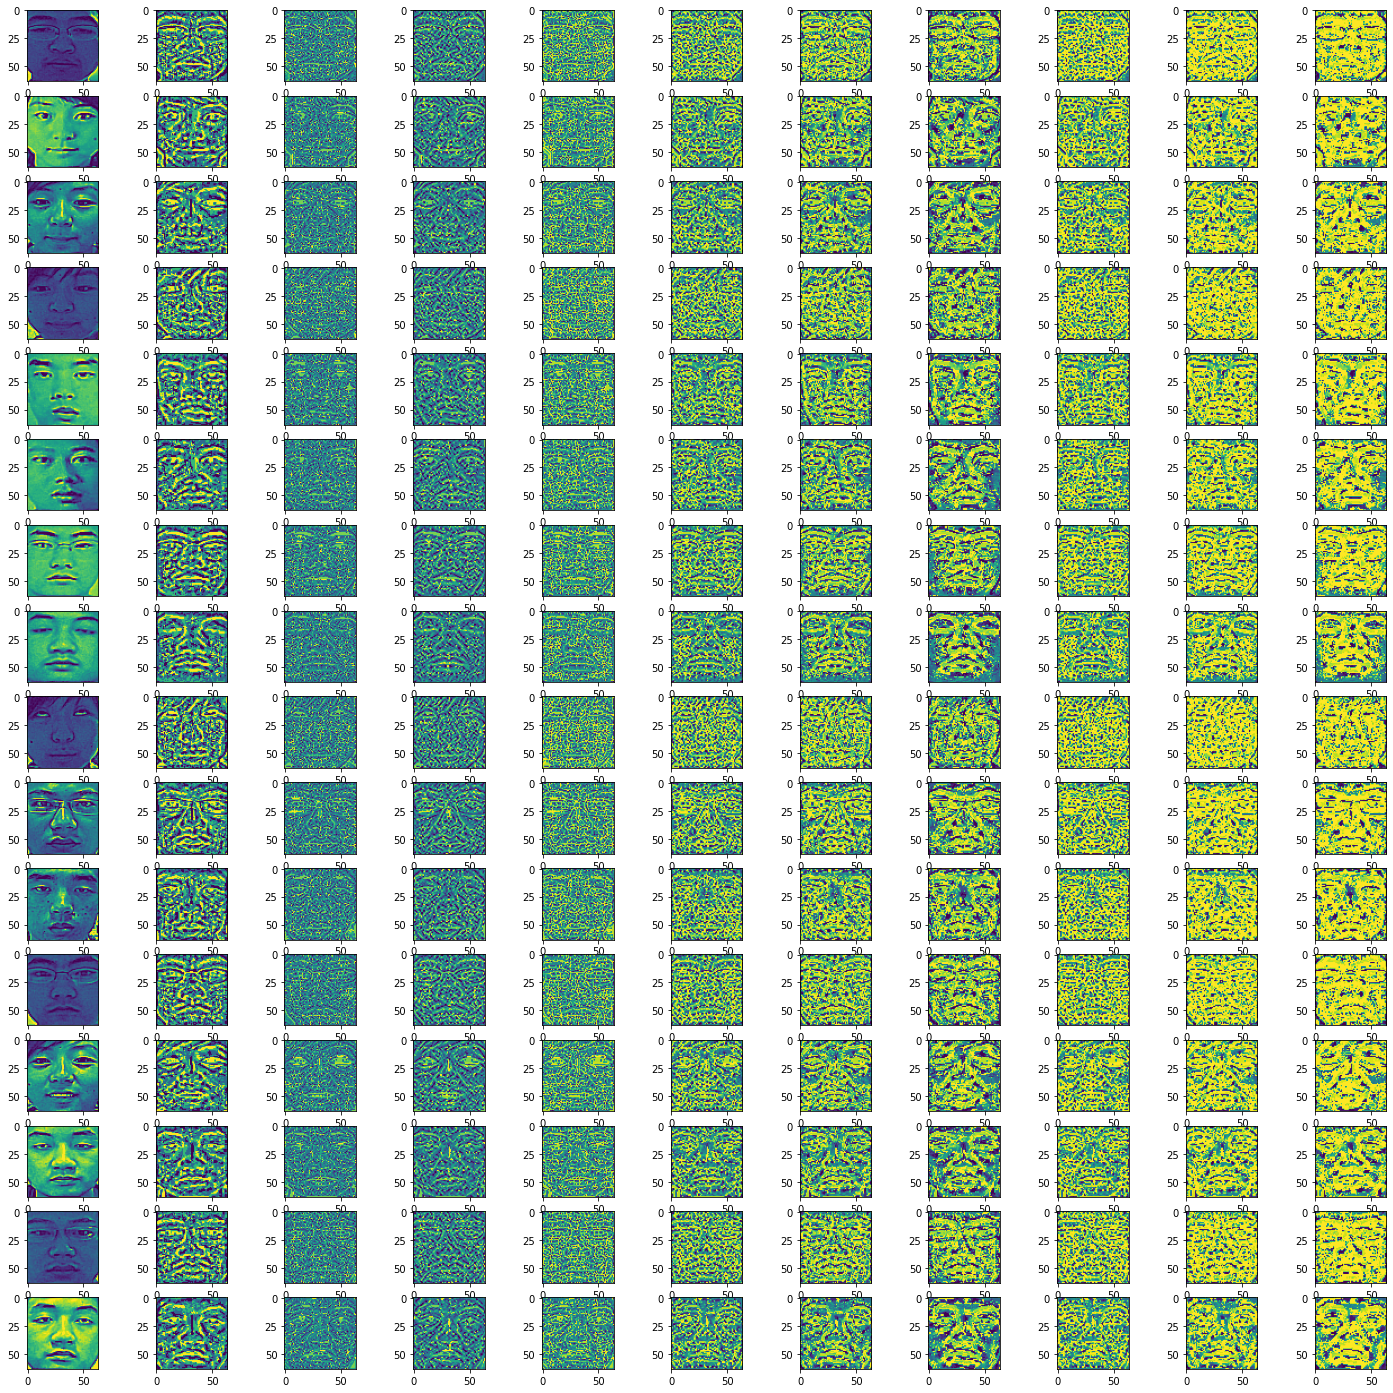

In [ ]:
print(f"label: {label}")
plot(batch)

#Helper functions

In [ ]:
# get true positives, true negatives,  false positives and false negatives

def confusion_matrix(ys, y_preds):
  ys=ys.detach()
  ys=ys.to("cpu")
  y_preds=y_preds.detach()
  y_preds=y_preds.to("cpu")

  ys=np.asarray(ys)
  y_preds=np.asarray(y_preds)  

  tp=np.sum((y_preds == 1) & (ys == 1))
  tn=np.sum((y_preds == 0) & (ys == 0))
  fp=np.sum((y_preds == 1) & (ys == 0))
  fn=np.sum((y_preds == 0) & (ys == 1))

  print(f"tp:{tp}, tn: {tn}, fp:{fp}, fn: {fn}") 

  return tp, tn, fp, fn

In [ ]:
# def confusion matrix test

a=torch.Tensor([1,1,1,0,0,0])
b=torch.Tensor([0,1,0,1,0,1])

TP, TN, FP, FN=confusion_matrix(a, b)
print(f"TP: {TP}, TN: {TN}, FP: {FP}, FN: {FN}")
print("Answer:TP: 1, TN: 1, FP: 2, FN: 2")

tp:1, tn: 1, fp:2, fn: 2
TP: 1, TN: 1, FP: 2, FN: 2
Answer:TP: 1, TN: 1, FP: 2, FN: 2


In [ ]:
# HTER claculation for test and validation
def HTER(model, loss_criterion, loader):
  Ys=list()
  Y_preds=list()
  Loss_total=0    
  total_step=len(loader)
  
  for touple, label in loader:
    batch=touple[0]
    batch=batch.to(device=device, dtype=torch.float)
    label=label.to(device=device, dtype=torch.long)
    Ys.append(label) 
    Y_pred=model(batch)       
    Y_preds.append(torch.argmax(Y_pred, dim=1))    
    Loss=loss_criterion(Y_pred,label)    
    Loss_total += Loss.item() 
    
    
  Y= torch.cat(Ys, dim=0)
  Y_pred=torch.cat(Y_preds, dim=0)
  tp, tn, fp, fn =confusion_matrix(Y, Y_pred)
  hter=1-(0.5*((tp/(tp+fn))+(tn/(tn+fp))))
  
  return (hter*100, Loss_total/total_step)

In [ ]:
# solver function for Neural Network

def Solver_NN(model, train_loader, test_loader, optim, criterion, device, print_every=10, epoch=51, lr=1e-1):
  print("Solver Initiated")  
  model=model.to(device) # sending model to GPU
  print("Model successfully sent to the GPU\n")

  print_every=print_every
  total_step = len(train_loader)
  counter=0

  for e in range(epoch):
    model.train()
    running_loss = 0.0    
    epoch_loss=0.0
    for i, (x,y) in enumerate(train_loader):
      optim.zero_grad()

      X=x[0]      
      X=X.to(device=device, dtype=torch.float)
      y=y.to(device=device, dtype=torch.long)
     
      #forward pass########
      y_pred=model(X)                  
      loss=criterion(y_pred, y)          
      ####################
      
      # backward pass#######     
      loss.backward()
      optim.step()
      ####################      
      running_loss += loss.item()
      epoch_loss+=running_loss
      if (i+1) % print_every == 0:       # print every 10
        print ("Epoch [{}/{}], Step [{}/{}] Loss: {}".format(counter+1, epoch, i+1, total_step, running_loss/print_every))
        running_loss = 0.0
    counter+=1     
    model.eval()
    with torch.no_grad():            
      train_hter, train_loss=HTER(model=model, loss_criterion=criterion, loader=train_loader)    
      test_hter, test_loss=HTER(model=model, loss_criterion=criterion, loader=test_loader)           
      print(f"Train loss in epoch {e+1} is {(train_loss)} and Train HTER in epoch {e+1}: {train_hter}") 
      print(f"Test loss in epoch {e+1} is {(test_loss)} and Test HTER in epoch {e+1}: {test_hter}")      
    torch.save(model.state_dict(), '/content/gdrive/HTER '+str(test_hter)+'.pkl') 
    print("Model saved successfully!\n")
    
  return model

# Neural Network

In [ ]:
class Resnet(nn.Module):
  def __init__(self, inp_channels, model):
    super().__init__()
    self.inp_channels=inp_channels
    self.first=nn.Sequential(nn.Conv2d(self.inp_channels, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False), nn.ReLU(inplace=True))
    self.cnn=nn.Sequential(*(list(model.children())[1:5]), nn.AdaptiveAvgPool2d(output_size=(1, 1)), nn.Flatten())    
    self.fc=nn.Sequential( nn.Linear(256, 128), nn.Dropout(p=0.5), nn.Linear(128, 64), nn.Dropout(p=0.5), nn.Linear(64, 2))     

  def forward(self, x):  

    x=self.first(x)
    #print(f"1: {x.shape}")

    x=self.cnn(x)
    #print(f"2: {x.shape}")

    x=self.fc(x)
    #print(f"3 {x.shape}")

    return x

In [ ]:
resnet=torch.hub.load('pytorch/vision:v0.6.0', 'resnet50', pretrained=False)
model= Resnet(num_input_channels, resnet )
print(model)

Downloading: "https://github.com/pytorch/vision/archive/v0.6.0.zip" to /root/.cache/torch/hub/v0.6.0.zip


Resnet(
  (first): Sequential(
    (0): Conv2d(10, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): ReLU(inplace=True)
  )
  (cnn): Sequential(
    (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (3): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (

In [ ]:
'''model.load_state_dict(torch.load(""))

<All keys matched successfully>

In [ ]:
#criterion and optimizer
from torch.optim.lr_scheduler import ReduceLROnPlateau

lr=0.01
criterion=nn.CrossEntropyLoss(reduction='mean') # loss criterion 
optim=torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.01) # optimizer 

In [ ]:
# GPU Access and model parameters
use_cuda = True
if use_cuda and torch.cuda.is_available():
  print("Running on Cuda")
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print("Learnable parameters:",params)

Running on Cuda
Learnable parameters: 288578


In [ ]:
# loading training and validation data for the neural network

train_loader=DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=8) 
test_loader=DataLoader(test_dataset, batch_size=64, shuffle=True, num_workers=8) 

In [ ]:
model=Solver_NN(model, train_loader, test_loader, optim,criterion, device,print_every=10, epoch=11, lr=lr)

Solver Initiated
Model successfully sent to the GPU

Epoch [1/11], Step [10/55] Loss: 1.7107491075992585
Epoch [1/11], Step [20/55] Loss: 0.7689820528030396
Epoch [1/11], Step [30/55] Loss: 0.6949819922447205
Epoch [1/11], Step [40/55] Loss: 0.467945459485054
Epoch [1/11], Step [50/55] Loss: 0.20851443521678448
tp:1605, tn: 1709, fp:39, fn: 138
tp:2181, tn: 4311, fp:1450, fn: 1181
Train loss in epoch 1 is 0.13550623553720387 and Train HTER in epoch 1: 5.074252551231407
Test loss in epoch 1 is 0.8037851313194195 and Test HTER in epoch 1: 30.148570755312676
Model saved successfully!

Epoch [2/11], Step [10/55] Loss: 0.09977618232369423
Epoch [2/11], Step [20/55] Loss: 0.06497000893577934
Epoch [2/11], Step [30/55] Loss: 0.08446219302713871
Epoch [2/11], Step [40/55] Loss: 0.08035531118512154
Epoch [2/11], Step [50/55] Loss: 0.17723770383745432
tp:1597, tn: 1712, fp:36, fn: 146
tp:1053, tn: 4010, fp:1751, fn: 2309
Train loss in epoch 2 is 0.19266305728392166 and Train HTER in epoch 2: 5.2

#Testing

In [ ]:

test_loader=DataLoader(test_dataset, batch_size=128, shuffle=True, num_workers=8) 
len_test_dataset= len(test_dataset)

print(f"Total number of elements in test dataset: {len_test_dataset}")

Total number of elements in test dataset: 9123


In [ ]:
criterion=nn.CrossEntropyLoss(reduction='mean') # loss criterion
resnet=torch.hub.load('pytorch/vision:v0.6.0', 'resnet50', pretrained=False)
model= Resnet(num_input_channels, resnet )


Downloading: "https://github.com/pytorch/vision/archive/v0.6.0.zip" to /root/.cache/torch/hub/v0.6.0.zip


In [ ]:
model.load_state_dict(torch.load("HTER 3.88.pkl"))

<All keys matched successfully>

In [ ]:
model=model.to(device)
model.eval()
with torch.no_grad():      
      test_hter, test_loss=HTER(model=model, loss_criterion=criterion, loader=test_loader)
      print(f"Test loss  is {(test_loss/len_test_dataset)}")
      print(f'Test HTER: {test_hter}\n')

tp:3301, tn: 5486, fp:275, fn: 61
Test loss  is 1.3809521907975738e-05
Test HTER: 3.293936509841089

